In [115]:
import pickle
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

sys.path.append(".")

from itertools import product
from pathlib import Path
from typing import Tuple, Dict, NewType, List

In [116]:
def get_runs(path: str):
    return [x for x in os.listdir(path) if "run" in x]

Figure = NewType('Figure', matplotlib.figure.Figure)
Axis   = NewType('Figure', matplotlib.axes.Axes)

def heat_plot(X: np.array, size: Tuple[int] = None,
              x_tick_labels: List[str] = None,
              y_tick_labels: List[str] = None,
              cmap: str = None,
              cbar: bool = False,
              fig: Figure = None,
              ax: Axis = None) -> Tuple[Figure, Axis]:
    if fig == None and ax == None:
        fig, ax = plt.subplots(1, 1)
        if size != None:
            fig.set_size_inches(size)
        else:
            fig.set_size_inches(w = 15, h = 10)
    
    sns.heatmap(X, linewidth = 0, ax = ax, cmap = cmap, cbar = cbar)
    
    ax.locator_params('x', nbins = 3)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))
    
    if x_tick_labels != None:
        ax.set_xticklabels(x_tick_labels)
    if y_tick_labels != None:
        ax.set_yticklabels(y_tick_labels)
    
    return fig, ax

def get_mean_stats(param_list: Dict, results_path: str, T: int) -> Dict:
    mean_stats = {}
        
    for param in product(*param_list.values()):
        input_path = Path(results_path) / str(param)
        try:
            runs = get_runs(input_path)
        except:
            continue
        
        mean_run_stats = {
            "Entropy": np.zeros(T),
            "Proximity": np.zeros(T),
            "Polarity": np.zeros(T),
            "Distribution": np.zeros((32, T))
        }
        
        num_runs = len(runs)
        
        for run in runs:
            stats = pickle.load(open(input_path / run, "rb"))
            mean_run_stats['Entropy'] += stats['Entropy']
            mean_run_stats['Proximity'] += stats['Proximity']
            mean_run_stats['Polarity'] += stats['Polarity']
            mean_run_stats['Distribution'] += np.array(stats['Distribution']).T
            
        mean_run_stats['Entropy'] /= num_runs
        mean_run_stats['Proximity'] /= num_runs
        mean_run_stats['Polarity'] /= num_runs
        mean_run_stats['Distribution'] /= num_runs
        
        mean_stats[param] = mean_run_stats
        
    return mean_stats

In [117]:
# Experiment's setup

param_list = {
    "graph_type": ["barabasi"],
    "network_size": [500],
    "memory_size": [160],
    "code_length": [5],
    "kappa": [0, 15, 30],
    "lambda": [0, 0.1, 0.3, 1, 5],
    "alpha": [1, 0.8, 0.6, 0.5, 0.4, 0.2],
    "omega": [0, 0.2, 0.4, 0.5, 0.6, 0.8],
    "gamma": [-10, 0, 10],
    "prefferential_att": [2]
}

experiment_path =  "/media/roboto/Tranqueiras/entropia_grafos_experimentos/experiment_barabasi_with_polarization"

simulated_params = [x for x in os.listdir(experiment_path) if '(' in x]

In [132]:
from typing import Tuple

def error_curve(
    results_path: str,
    params: Tuple,
    T: int,
) -> Dict[str, List[float]]:
    entropy_abs_dif   = []
    proximity_abs_dif = []
    polarity_abs_dif  = []
    
    (mean_entropy_i,
     mean_entropy_f)   = (np.zeros(T),
                          np.zeros(T))
    (mean_proximity_i,
     mean_proximity_f) = (np.zeros(T),
                          np.zeros(T))
    
    (mean_polarity_i,
     mean_polarity_f)  = (np.zeros(T),
                          np.zeros(T))

    entropy_sum   = np.zeros(T)
    proximity_sum = np.zeros(T)
    polarity_sum  = np.zeros(T)
    
    input_path = Path(results_path) / str(param)
    runs = get_runs(input_path)
    
    for k, run in enumerate(runs):
        n = k + 1
        
        stats = pickle.load(open(input_path / run, "rb"))
        
        entropy   = stats['Entropy']
        proximity = stats['Proximity']
        polarity  = stats['Polarity']
        
        entropy_sum   += entropy
        proximity_sum += proximity
        polarity_sum  += polarity
        
        
        mean_entropy_f   = entropy_sum / n
        mean_proximity_f = proximity_sum / n
        mean_polarity_f  = polarity_sum / n
        
        
        entropy_abs_mean_difference   = np.abs((mean_entropy_f - mean_entropy_i).sum())
        proximity_abs_mean_difference = np.abs((mean_proximity_f - mean_proximity_i).sum())
        polarity_abs_mean_difference  = np.abs((mean_polarity_f - mean_proximity_i).sum())
        
        print("Mean Absolute Difference between runs {} and {}".format(n, n - 1))
        print("{0: <34}: {:0.10f}".format("Entropy Mean Absolute Difference", entropy_abs_mean_difference))
        print("{0: <34}: {:0.10f}".format("Proximity Mean Absolute Difference", proximity_abs_mean_difference))
        print("{0: <34}: {:0.10f}".format("Polarity Mean Absolute Difference", polarity_abs_mean_difference))
        
        entropy_abs_dif.append(entropy_abs_mean_difference)
        proximity_abs_dif.append(proximity_abs_mean_difference)
        polarity_abs_dif.append(polarity_abs_mean_difference)
        
        mean_entropy_i = mean_entropy_f
        mean_proximity_i = mean_proximity_f
        mean_polarity_i = mean_polarity_f
        
    return {
        "entropy": entropy_abs_dif,
        "proximity": proximity_abs_dif,
        "poalrity_abs_dif": polarity_abs_dif
    }

In [131]:
results_path = "/media/roboto/Tranqueiras/entropia_grafos_experimentos/experiment_barabasi_with_polarization"
param = list(product(*param_list.values()))[0]
T = 500

input_path = Path(results_path) / str(param)
runs = get_runs(input_path)

(mean_entropy_i,
 mean_entropy_f) = (np.zeros(T),
                    np.zeros(T))
(mean_proximity_i,
 mean_proximity_f) = (np.zeros(T),
                      np.zeros(T))

entropy_sum = np.zeros(T)
proximity_sum = np.zeros(T)

for k, run in enumerate(runs):
    n = k + 1
    
    stats = pickle.load(open(input_path / run, "rb"))
    entropy   = stats['Entropy']
    proximity = stats['Proximity']
    entropy_sum   += entropy
    proximity_sum += proximity
    mean_entropy_f   = entropy_sum / n
    mean_proximity_f = proximity_sum / n
    
    entropy_abs_difference = np.abs((mean_entropy_f - mean_entropy_i)).mean()
    proximity_abs_difference = np.abs((mean_proximity_f - mean_proximity_i)).mean()
    
    print("Mean Absolute Difference between runs {} and {}".format(n, n - 1))
    print("{0: <34}: {1:0.10f}".format("Entropy Mean Absolute Difference", entropy_abs_difference))
    print("{0: <34}: {1:0.10f}".format("Proximity Mean Absolute Difference", proximity_abs_difference))
    print()
    
    mean_entropy_i = mean_entropy_f
    mean_proximity_i = mean_proximity_f
    

Mean Absolute Difference between runs 1 and 0
Entropy Mean Absolute Difference  : 3.6874454160
Proximity Mean Absolute Difference: 0.7540626647

Mean Absolute Difference between runs 2 and 1
Entropy Mean Absolute Difference  : 0.0019953084
Proximity Mean Absolute Difference: 0.0011467879

Mean Absolute Difference between runs 3 and 2
Entropy Mean Absolute Difference  : 0.0007810714
Proximity Mean Absolute Difference: 0.0006524272

Mean Absolute Difference between runs 4 and 3
Entropy Mean Absolute Difference  : 0.0005900122
Proximity Mean Absolute Difference: 0.0007568847

Mean Absolute Difference between runs 5 and 4
Entropy Mean Absolute Difference  : 0.0003518862
Proximity Mean Absolute Difference: 0.0003942282



In [130]:
len("Proximity Mean Absolute Difference")

34

In [53]:
mean_stats = get_mean_stats(param_list, experiment_path, T = 500)

In [54]:
with open("mean_stats_barabasi_polarization.pkl", "wb") as file:
    pickle.dump(mean_stats, file)

In [4]:
mean_stats = pickle.load(open("mean_stats_barabasi_polarization.pkl", "rb"))

***

### Cenário 1: Um único grupo polarizado.

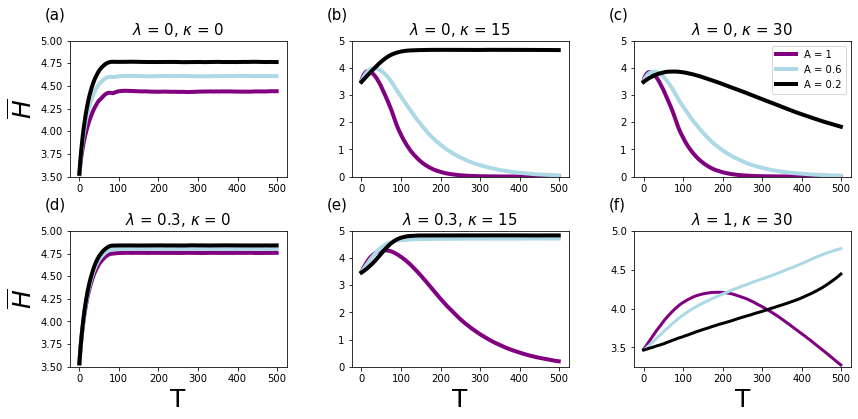

In [99]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (14, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)

for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
axs[0, 0].set_ylim([3.5, 5])
axs[0, 1].set_ylim([0, 5])
axs[0, 2].set_ylim([0, 5])
axs[1, 0].set_ylim([3.5, 5])
axs[1, 1].set_ylim([0, 5])
axs[1, 2].set_ylim([3.25, 5])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.3]
alpha = [1, 0.6, 0.2]

for i in range(len(alpha)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                param = ("barabasi", 500, 160, 5, kappas[j], lambdas[k], alpha[i], 0, 0, 2)

                results = mean_stats[param]
                mean_entropy = results['Entropy']
                X = range(len(mean_entropy))

                axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 4)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
            
            
for i in range(len(alpha)):
    param = ("barabasi", 500, 160, 5, 30, 1, alpha[i], 0, 0, 2)

    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))

    axs[1][2].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

    axs[1][2].set_title(rf"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)

axs[0][2].legend(fontsize = 10, loc = 1)



fig.savefig("cenario_2_entropia_gamma_0_grupamento_0.png", bbox_inches = "tight")

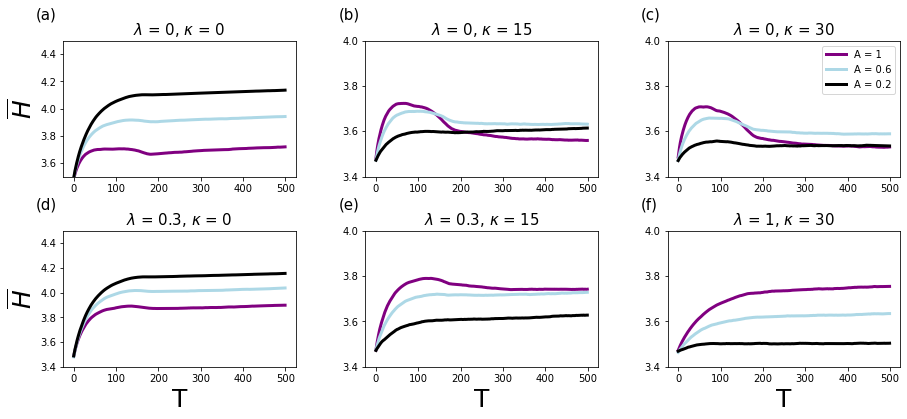

In [109]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)
    
for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
axs[0, 0].set_ylim([3.5, 4.5])
axs[0, 1].set_ylim([3.4, 4])
axs[0, 2].set_ylim([3.4, 4])
axs[1, 0].set_ylim([3.4, 4.5])
axs[1, 1].set_ylim([3.4, 4])
axs[1, 2].set_ylim([3.4, 4])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.3]

alpha = [1, 0.6, 0.2]

for i in range(len(alpha)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                param = ("barabasi", 500, 160, 5, kappas[j], lambdas[k], alpha[i], 0, -10, 2)

                results = mean_stats[param]
                mean_entropy = results['Entropy']
                X = range(len(mean_entropy))

                axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
            
            
for i in range(len(alpha)):
    param = ("barabasi", 500, 160, 5, 30, 1, alpha[i], 0, -10, 2)

    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))

    axs[1][2].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

    axs[1][2].set_title(f"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)

axs[0][2].legend(fontsize = 10, loc = 1)

fig.savefig("cenario_2_entropia_gamma_negativo_grupamento_0.png", bbox_inches = "tight")

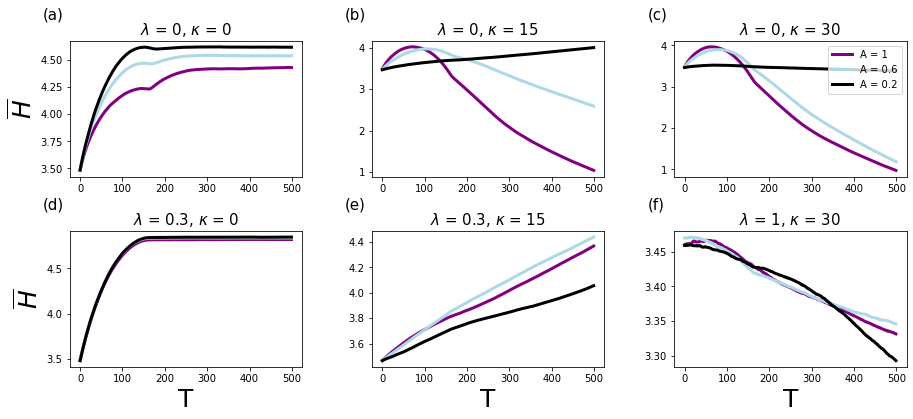

In [111]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)
    
for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
# axs[0, 0].set_ylim([3.5, 4.5])
# axs[0, 1].set_ylim([3.4, 4])
# axs[0, 2].set_ylim([3.4, 4])
# axs[1, 0].set_ylim([3.4, 4.5])
# axs[1, 1].set_ylim([3.4, 4])
# axs[1, 2].set_ylim([3.4, 4])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.3]

alpha = [1, 0.6, 0.2]

for i in range(len(alpha)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                param = ("barabasi", 500, 160, 5, kappas[j], lambdas[k], alpha[i], 0, 10, 2)

                results = mean_stats[param]
                mean_entropy = results['Entropy']
                X = range(len(mean_entropy))

                axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
            
            
for i in range(len(alpha)):
    param = ("barabasi", 500, 160, 5, 30, 1, alpha[i], 0, 10, 2)

    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))

    axs[1][2].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

    axs[1][2].set_title(f"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)

axs[0][2].legend(fontsize = 10, loc = 1)

fig.savefig("cenario_2_entropia_gamma_positivo_grupamento_0.png", bbox_inches = "tight")

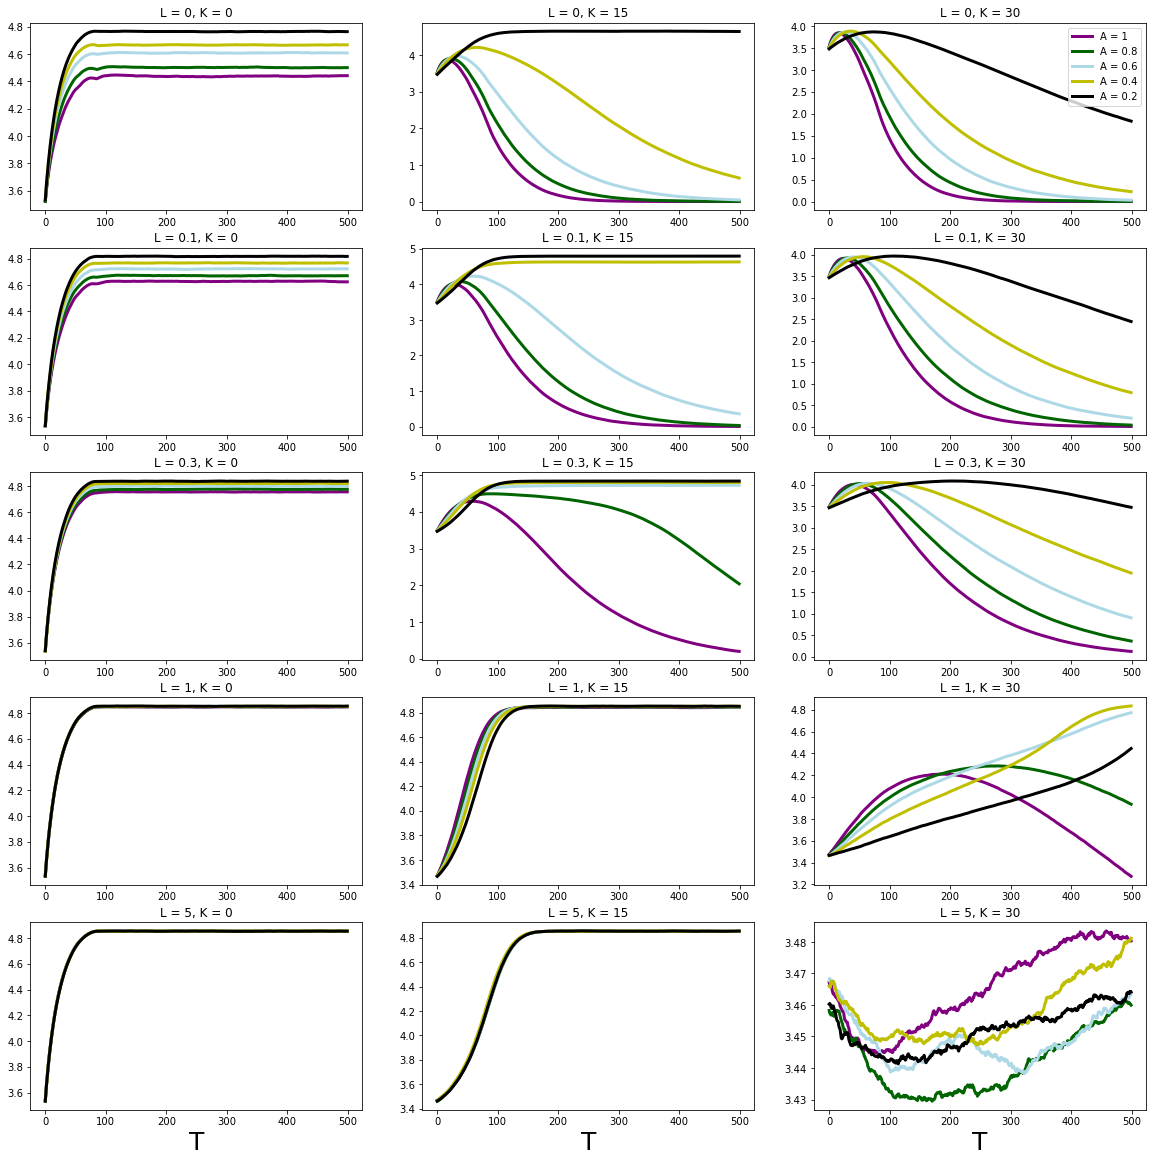

In [21]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

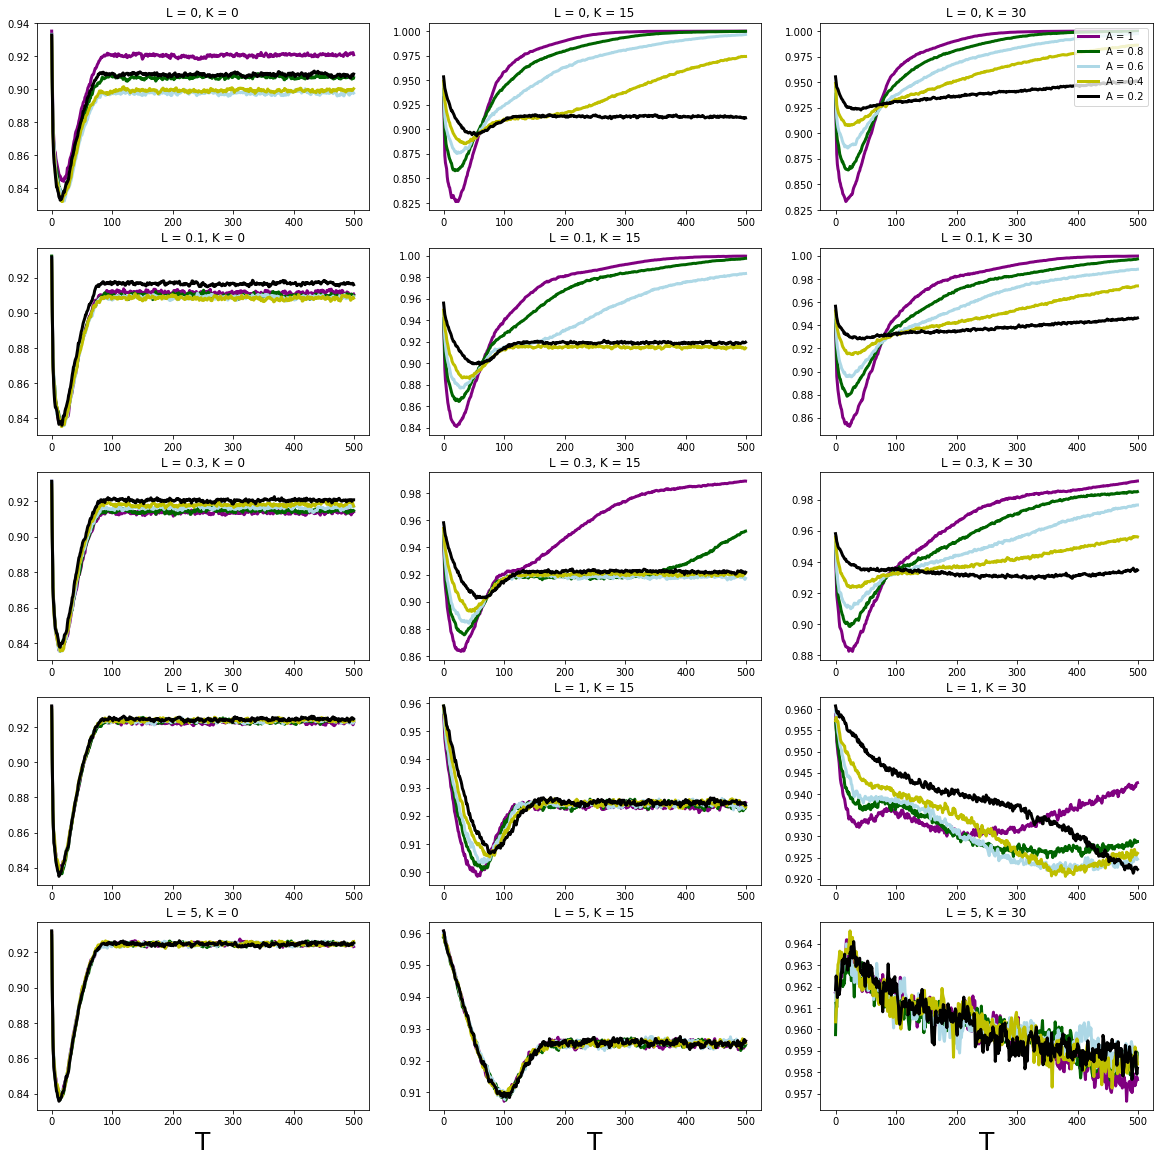

In [63]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, 0, 2)

            results = mean_stats[param]
            mean_proximity = results['Proximity']
            X = range(len(mean_proximity))

            axs[k][j].plot(X, mean_proximity, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

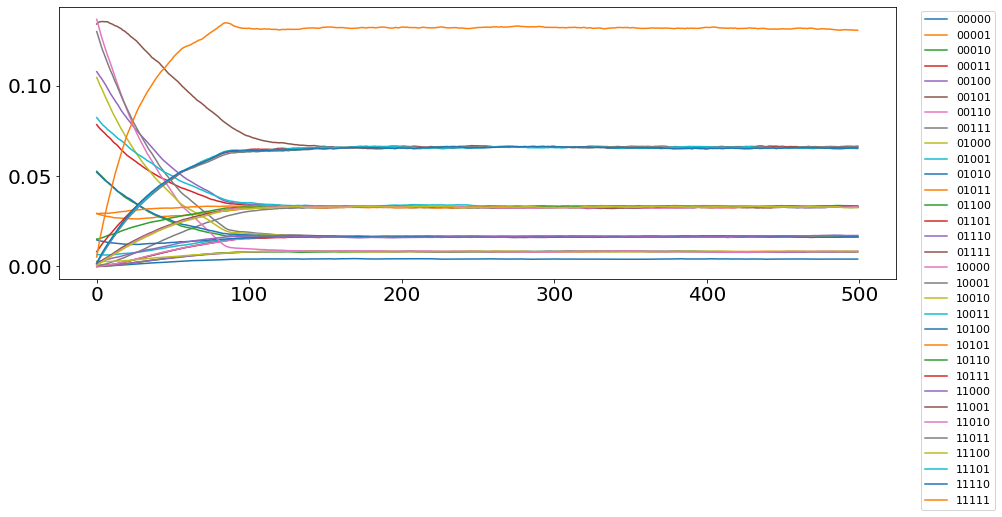

In [26]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 0
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

Text(0.5, 1.0, '$\\kappa = 15$ - $\\lambda = 0.3$ - $\\alpha = 1$')

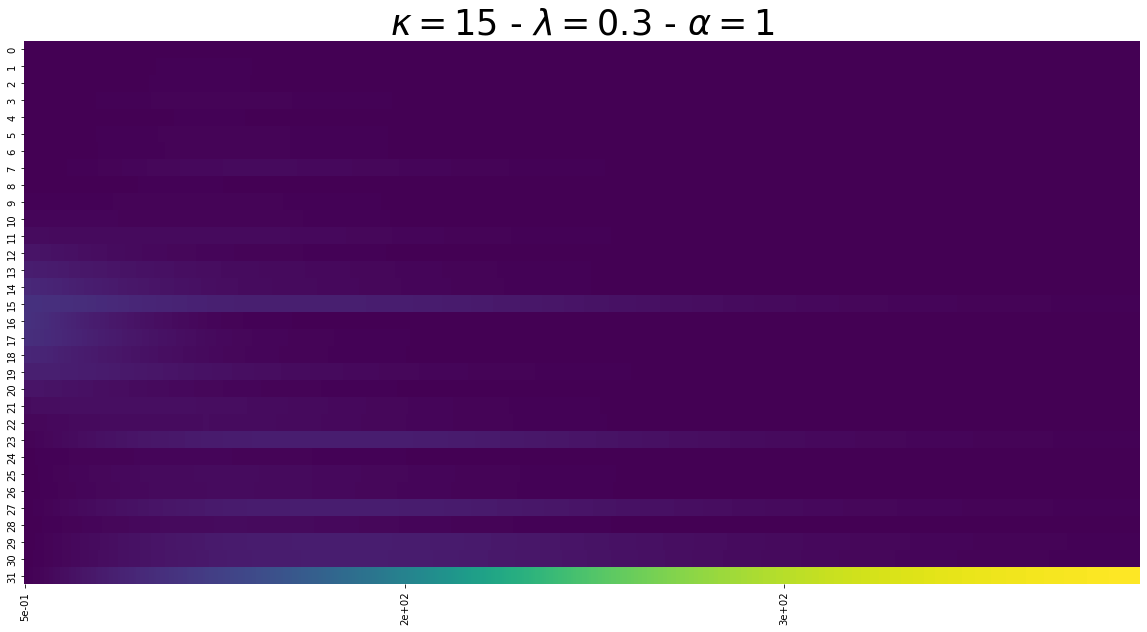

In [25]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.subplots_adjust(wspace = 0.05)

lambd = 0.3
kappa = 15
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax)
ax.set_title(r"$\kappa = 15$ - $\lambda = 0.3$ - $\alpha = 1$", fontsize = 35)

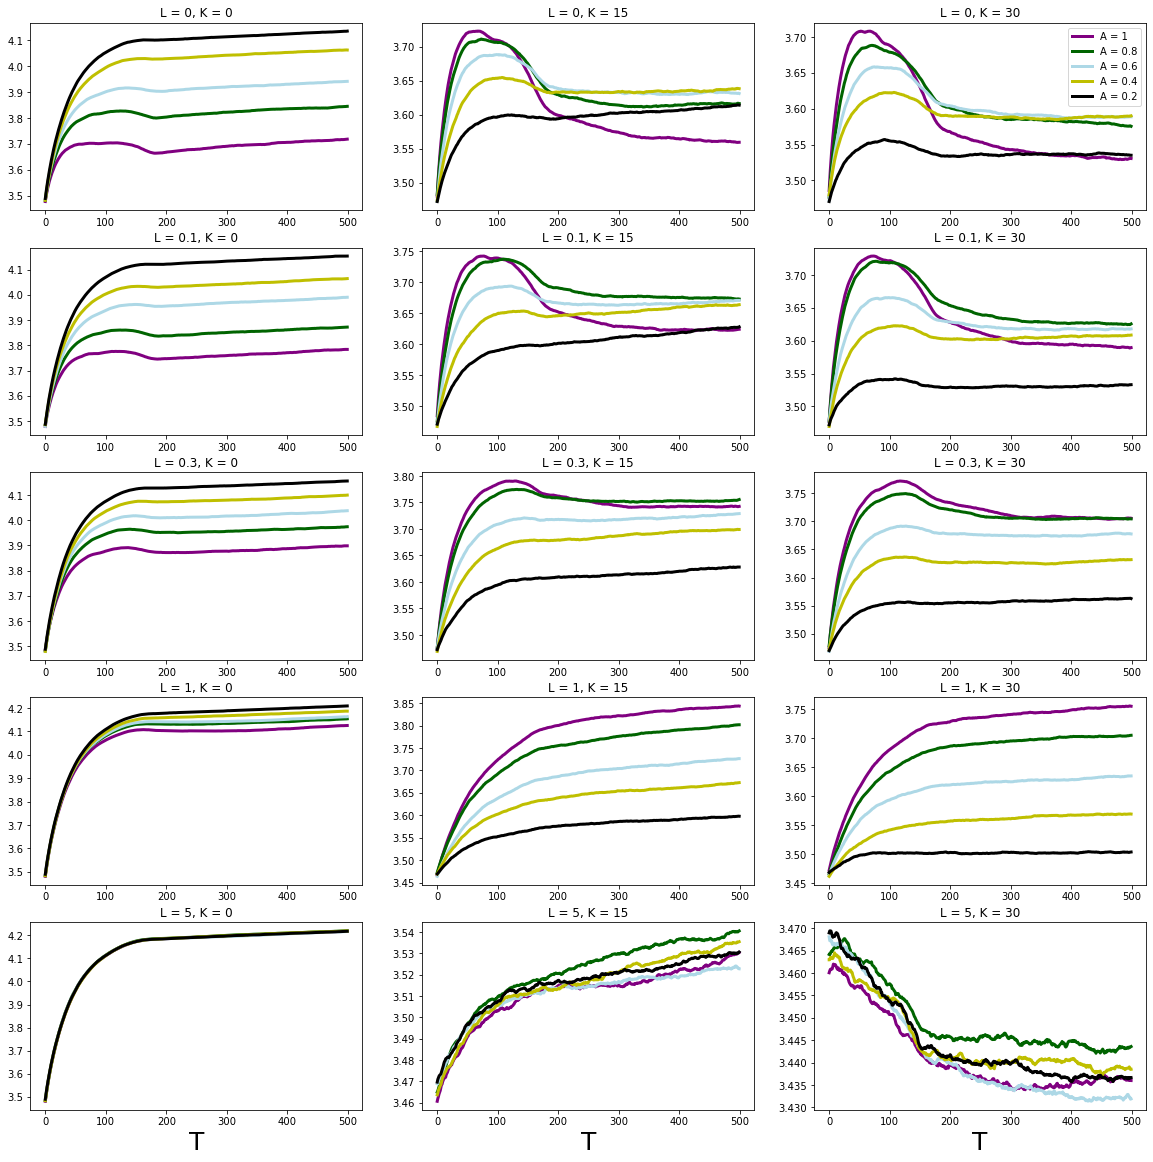

In [6]:
#### Gamma Negativo

fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, -10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

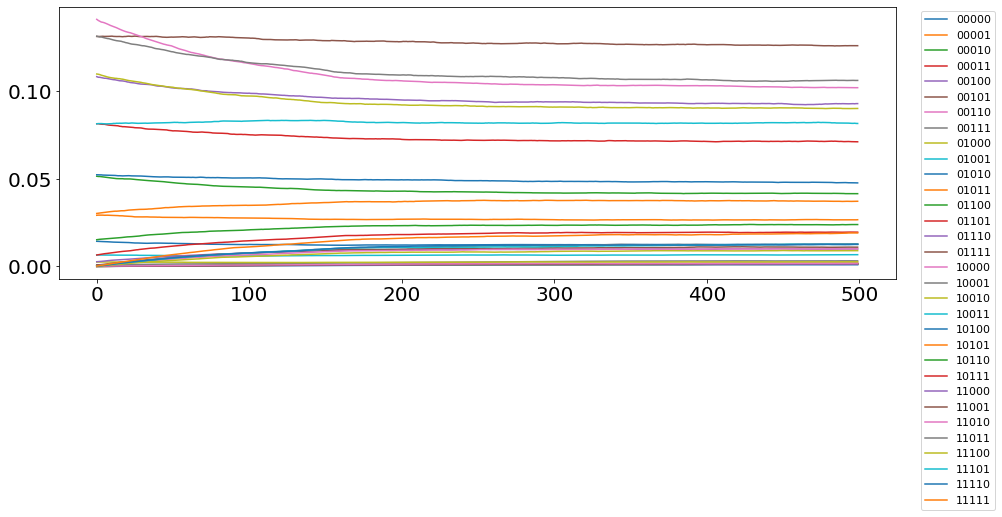

In [18]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 1
kappa = 15
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, -10, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

Text(0.5, 1.0, '$\\kappa = 15$ - $\\lambda = 0.3$ - $\\alpha = 1$')

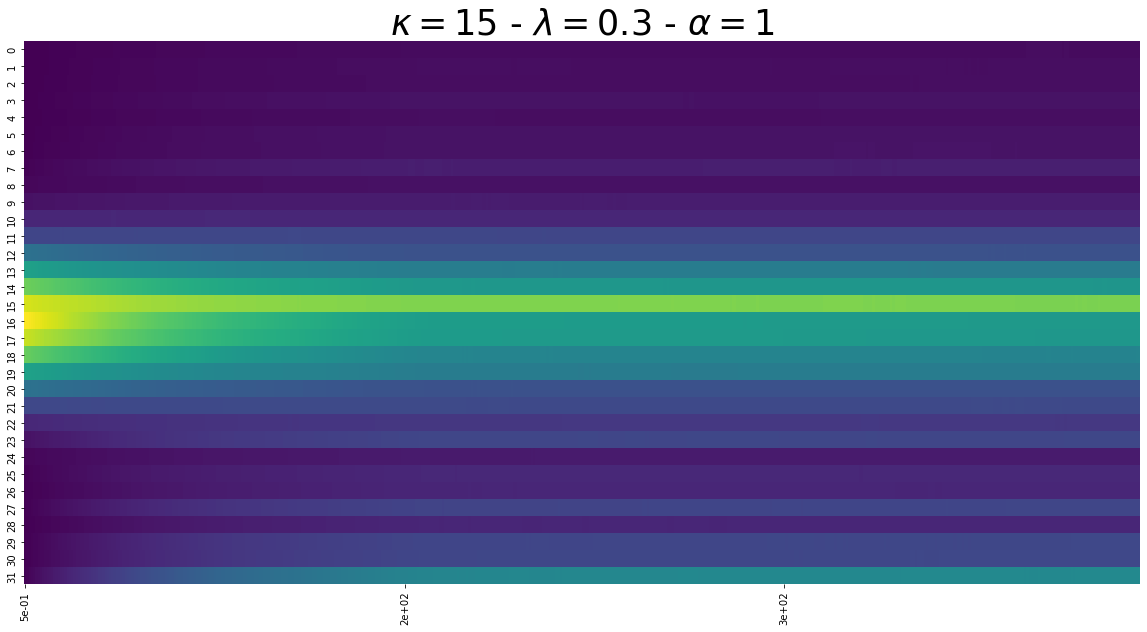

In [28]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.subplots_adjust(wspace = 0.05)

lambd = 0.3
kappa = 0
alpha = 0.8

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, -10, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax)
ax.set_title(r"$\kappa = 15$ - $\lambda = 0.3$ - $\alpha = 1$", fontsize = 35)

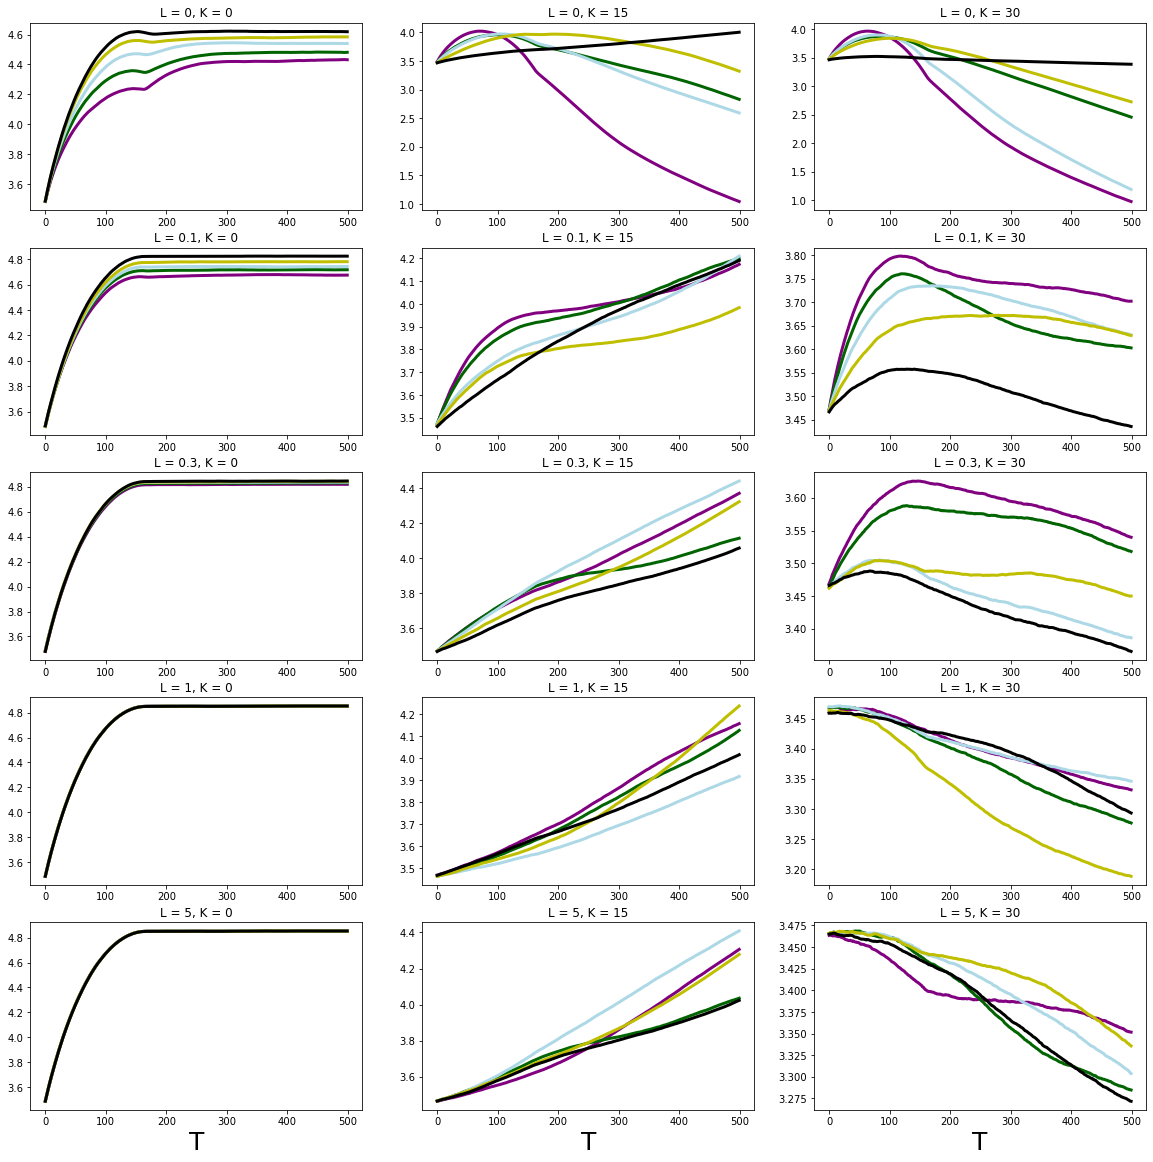

In [22]:
### Gamma Positivo

fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    1: "purple",
    0.8: "darkgreen",
    0.6: "lightblue",
    0.4: "y",
    0.2: "k"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha[i], 0, 10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A = {alpha[i]}', color = colors[alpha[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

Text(0.5, 1.0, '$\\kappa = 15$ - $\\lambda = 0.3$ - $\\alpha = 1$')

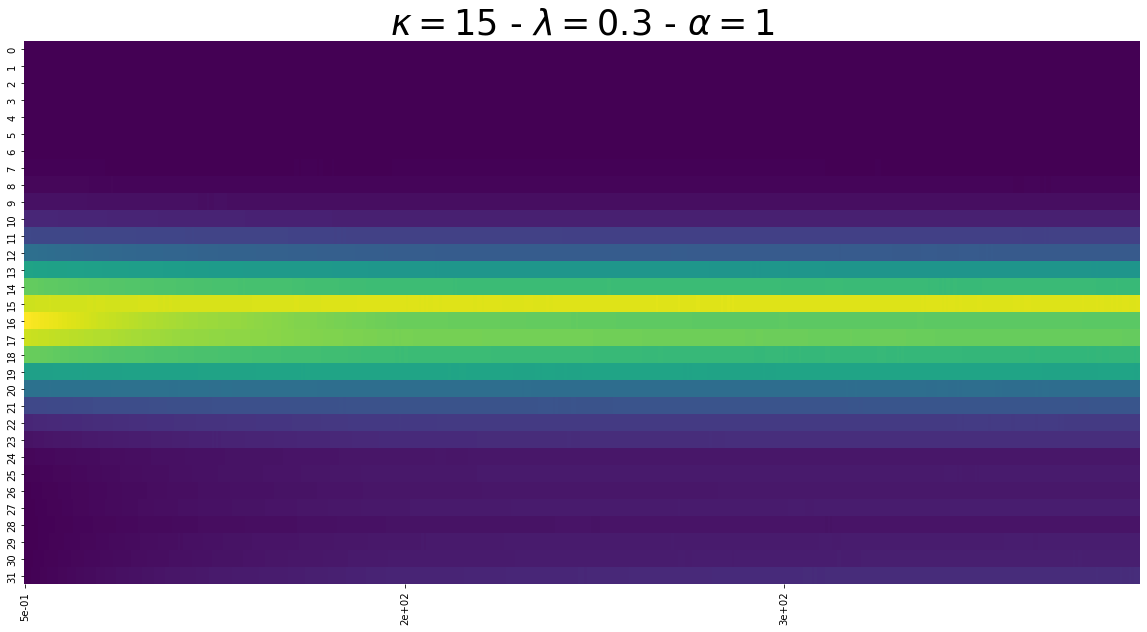

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 10))
fig.subplots_adjust(wspace = 0.05)

lambd = 1
kappa = 30
alpha = 1

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, 0, -10, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax)
ax.set_title(r"$\kappa = 15$ - $\lambda = 0.3$ - $\alpha = 1$", fontsize = 35)

### Cenário 2 - Dois grupos polarizados, um neutro.

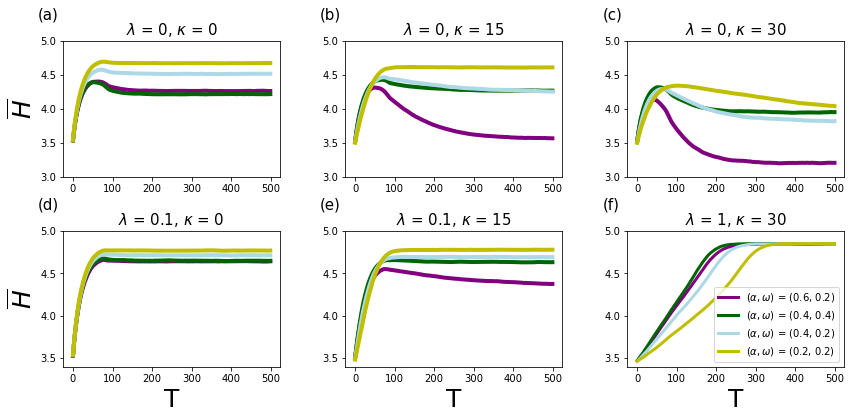

In [64]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (14, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)

for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
axs[0, 0].set_ylim([3.0, 5])
axs[0, 1].set_ylim([3.0, 5])
axs[0, 2].set_ylim([3.0, 5])
axs[1, 0].set_ylim([3.4, 5])
axs[1, 1].set_ylim([3.4, 5])
axs[1, 2].set_ylim([3.4, 5])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.1]
alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

for i in range(len(alpha_omega)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                alpha, omega = alpha_omega[i]
                param = ("barabasi", 500, 160, 5, kappas[j], lambdas[k], alpha, omega, 0, 2)

                results = mean_stats[param]
                mean_entropy = results['Entropy']
                X = range(len(mean_entropy))

                axs[k][j].plot(X, mean_entropy, label = fr'($\alpha, \omega$) = ({alpha}, {omega})', color = colors[alpha_omega[i]], linewidth = 4)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
            
            
for i in range(len(alpha_omega)):
    alpha, omega = alpha_omega[i]
    param = ("barabasi", 500, 160, 5, 30, 1, alpha, omega, 0, 2)

    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))

    axs[1][2].plot(X, mean_entropy, label =  rf'($\alpha, \omega$) = ({alpha}, {omega})', color = colors[alpha_omega[i]], linewidth = 3)

    axs[1][2].set_title(rf"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)

axs[1][2].legend(fontsize = 10, loc = 4)



fig.savefig("cenario_2_grupamento_0_entorpia.png", bbox_inches = "tight")

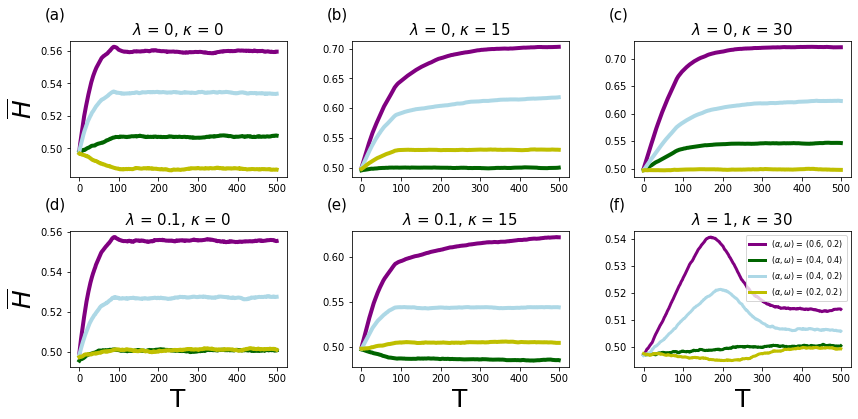

In [65]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (14, 6))
fig.subplots_adjust(hspace = 0.4, wspace = 0.30)
for ax in axs[1]:
    ax.set_xlabel("T", fontsize = 25)

for k in [0, 1]:
    axs[k][0].set_ylabel(r"$\overline{H}$", fontsize = 25)
    
# axs[0, 0].set_ylim([3.0, 5])
# axs[0, 1].set_ylim([3.0, 5])
# axs[0, 2].set_ylim([3.0, 5])
# axs[1, 0].set_ylim([3.4, 5])
# axs[1, 1].set_ylim([3.4, 5])
# axs[1, 2].set_ylim([3.4, 5])

fig.text(0.10, 0.93, "(a)", fontsize = 15)
fig.text(0.38, 0.93, "(b)", fontsize = 15)
fig.text(0.66, 0.93, "(c)", fontsize = 15)
fig.text(0.10, 0.49, "(d)", fontsize = 15)
fig.text(0.38, 0.49, "(e)", fontsize = 15)
fig.text(0.66, 0.49, "(f)", fontsize = 15)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

kappas = [0, 15, 30]
lambdas = [0, 0.1]
alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

for i in range(len(alpha_omega)):
    for j in range(len(kappas)):
        for k in range(len(lambdas)):
            if j == 2 and k == 1:
                pass
            else:
                alpha, omega = alpha_omega[i]
                param = ("barabasi", 500, 160, 5, kappas[j], lambdas[k], alpha, omega, 0, 2)

                results = mean_stats[param]
                mean_polarity = results['Polarity']
                X = range(len(mean_polarity))

                axs[k][j].plot(X, mean_polarity, label = fr'($\alpha, \omega$) = ({alpha}, {omega})', color = colors[alpha_omega[i]], linewidth = 4)

                axs[k][j].set_title(rf"$\lambda$ = {lambdas[k]}, $\kappa$ = {kappas[j]}", fontsize = 15)
            
            
for i in range(len(alpha_omega)):
    alpha, omega = alpha_omega[i]
    param = ("barabasi", 500, 160, 5, 30, 1, alpha, omega, 0, 2)

    results = mean_stats[param]
    mean_polarity = results['Polarity']
    X = range(len(mean_polarity))

    axs[1][2].plot(X, mean_polarity, label =  rf'($\alpha, \omega$) = ({alpha}, {omega})', color = colors[alpha_omega[i]], linewidth = 3)

    axs[1][2].set_title(rf"$\lambda$ = {1}, $\kappa$ = {30}", fontsize = 15)

axs[1][2].legend(fontsize = 8, loc = 1)



fig.savefig("cenario_2_grupamento_0_polaridade.png", bbox_inches = "tight")

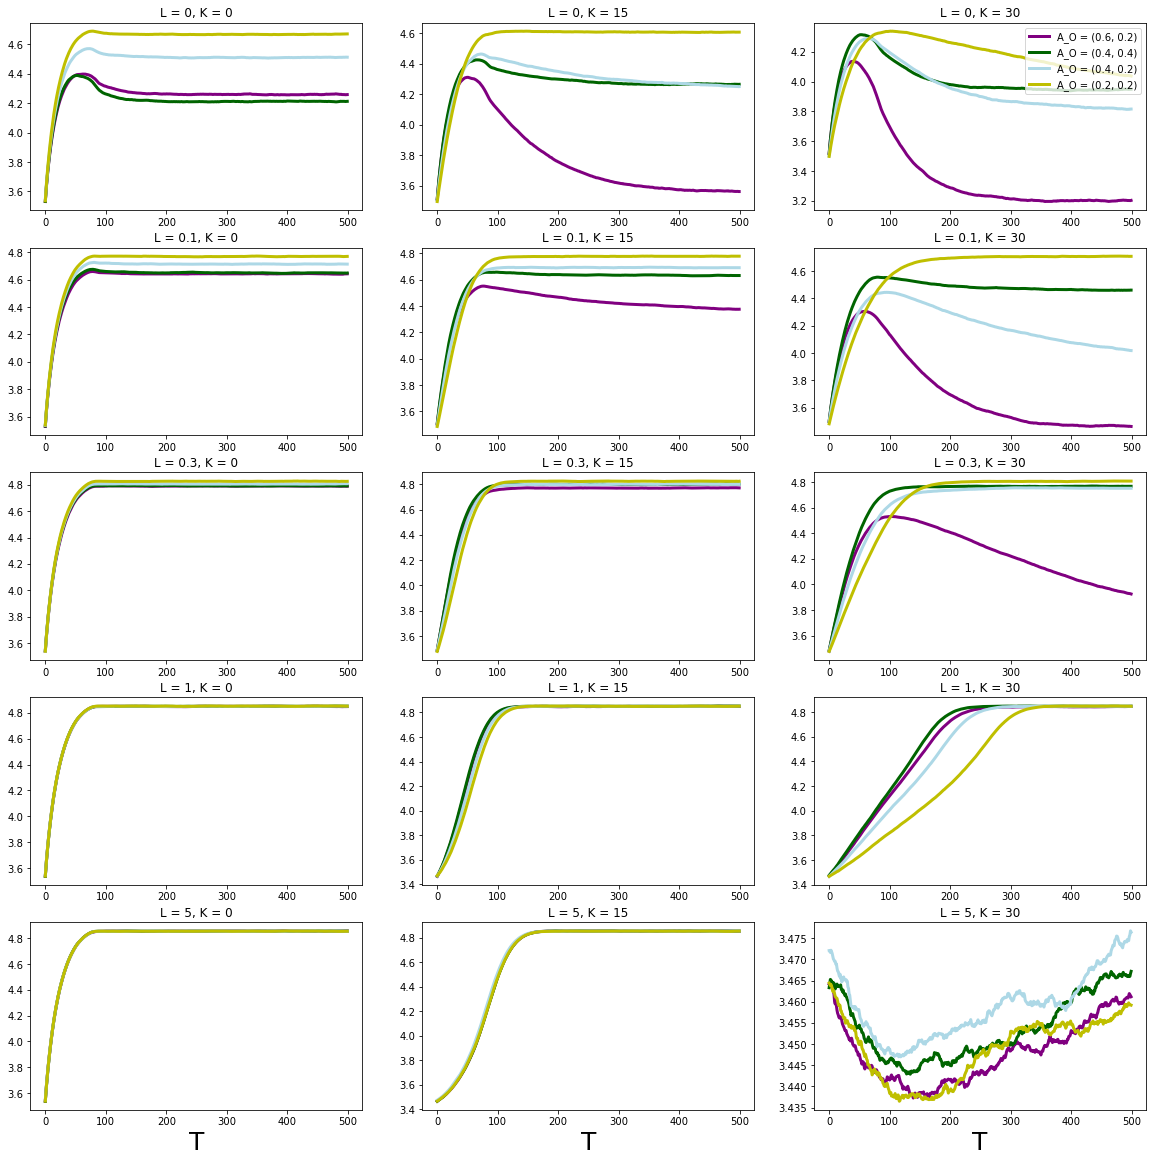

In [57]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

Text(0.5, 1.0, '$\\kappa = 30$ - $\\lambda = 0.3$ - $\\alpha = 0.2$ - $\\omega = 0.2$')

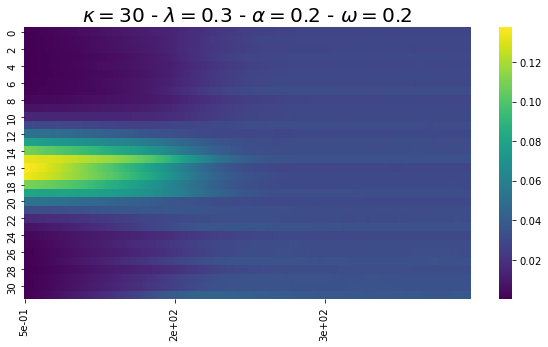

In [69]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 5))
# fig.subplots_adjust(hspace = 0.28)

lambd = 1
kappa = 30
alpha = 0.6
omega = 0.2

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = axs, cbar = True)
ax.set_title(r"$\kappa = 30$ - $\lambda = 0.3$ - $\alpha = 0.2$ - $\omega = 0.2$", fontsize = 20)

# fig.savefig("cenario_2_grupamento_0_dist_evolucao.png", bbox_inches = "tight")

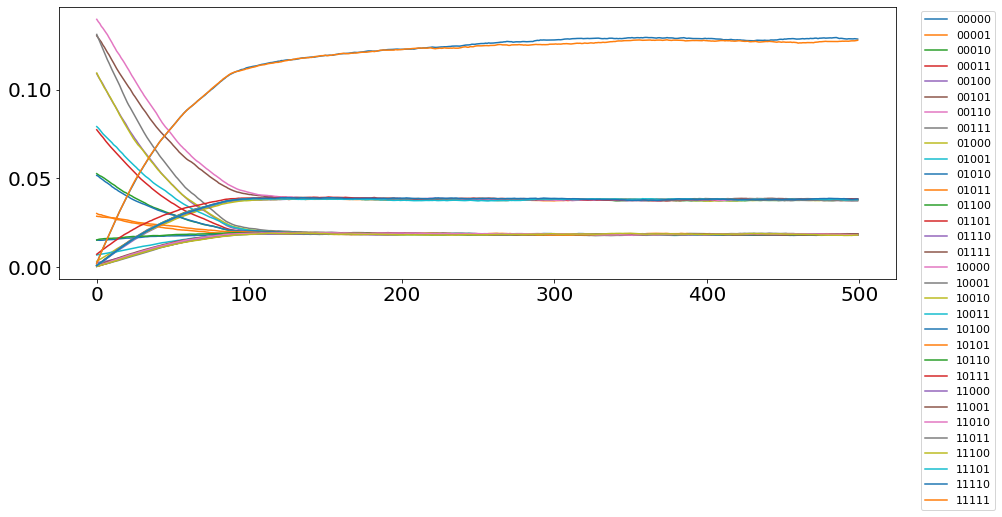

In [28]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 15
alpha = 0.4
omega = 0.4

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

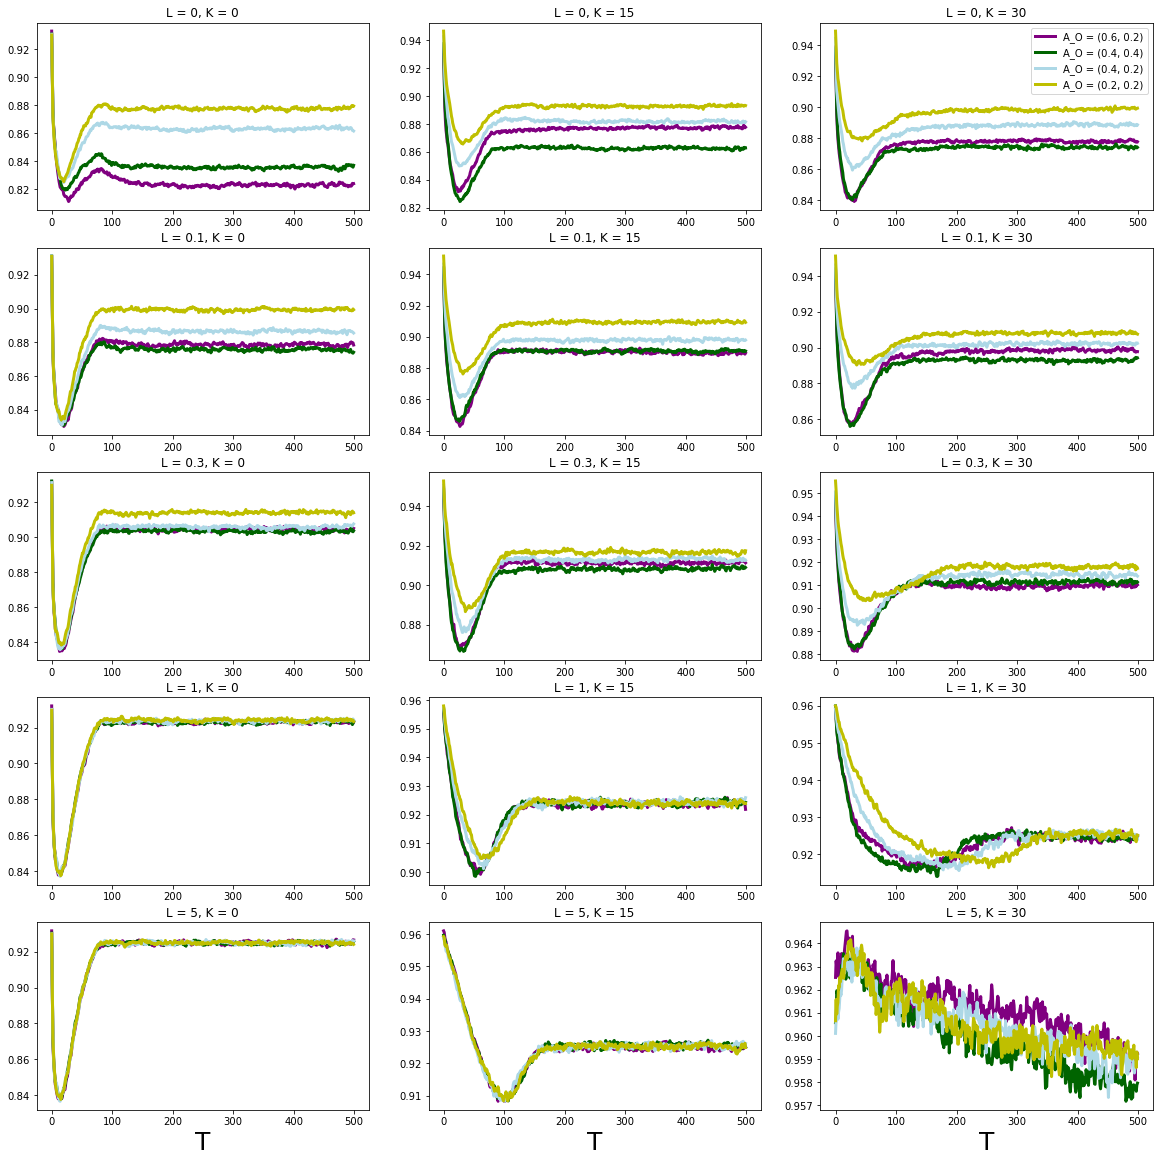

In [62]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_proximity = results['Proximity']
            X = range(len(mean_proximity))

            axs[k][j].plot(X, mean_proximity, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

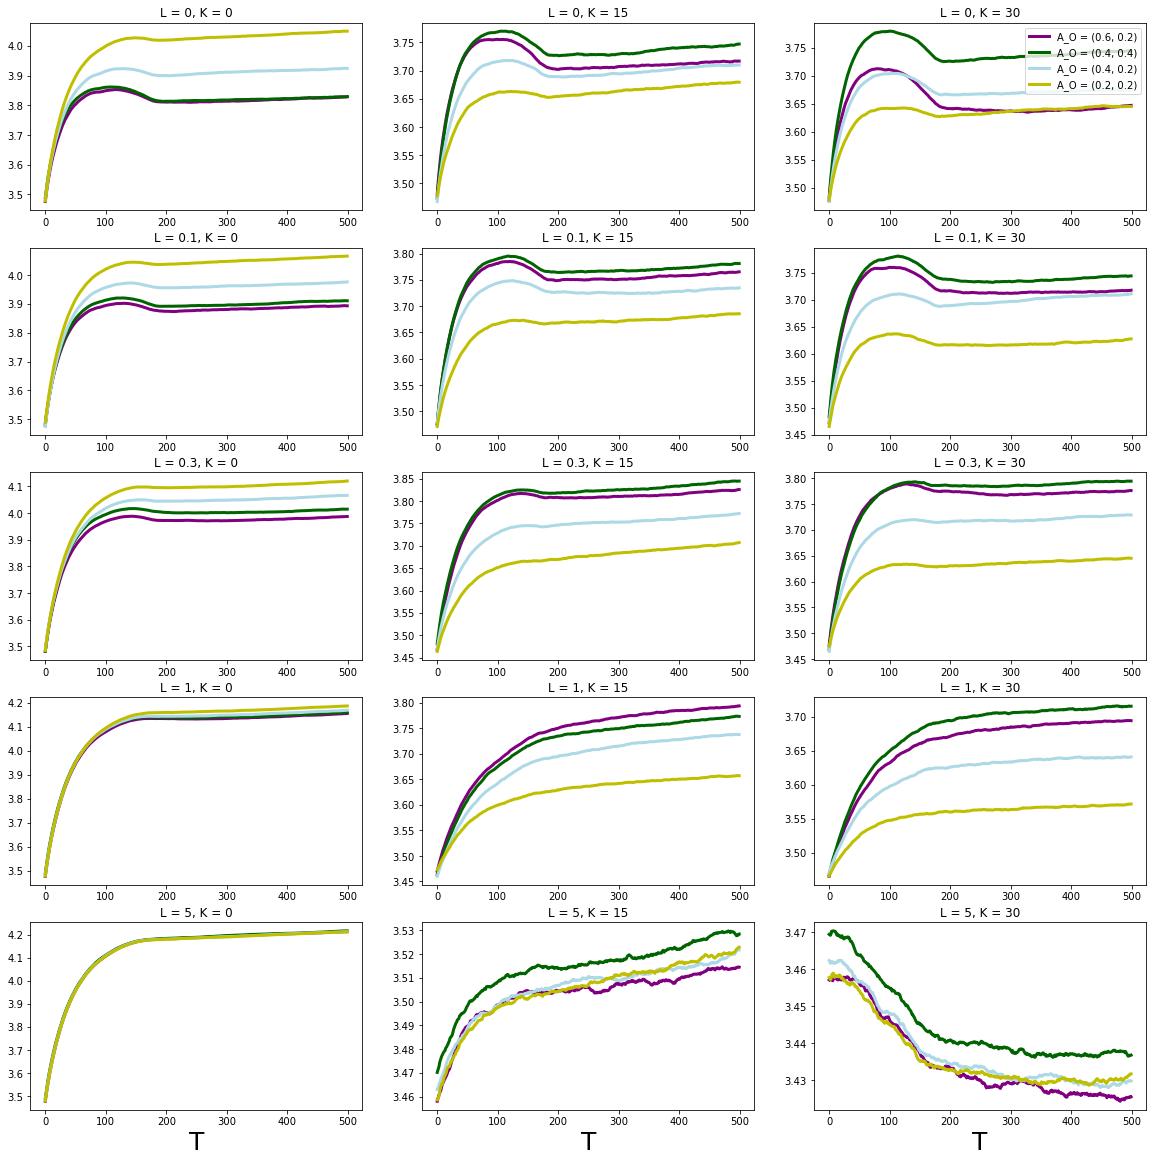

In [21]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], -10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
axs[0][2].legend(fontsize = 10, loc = 1)

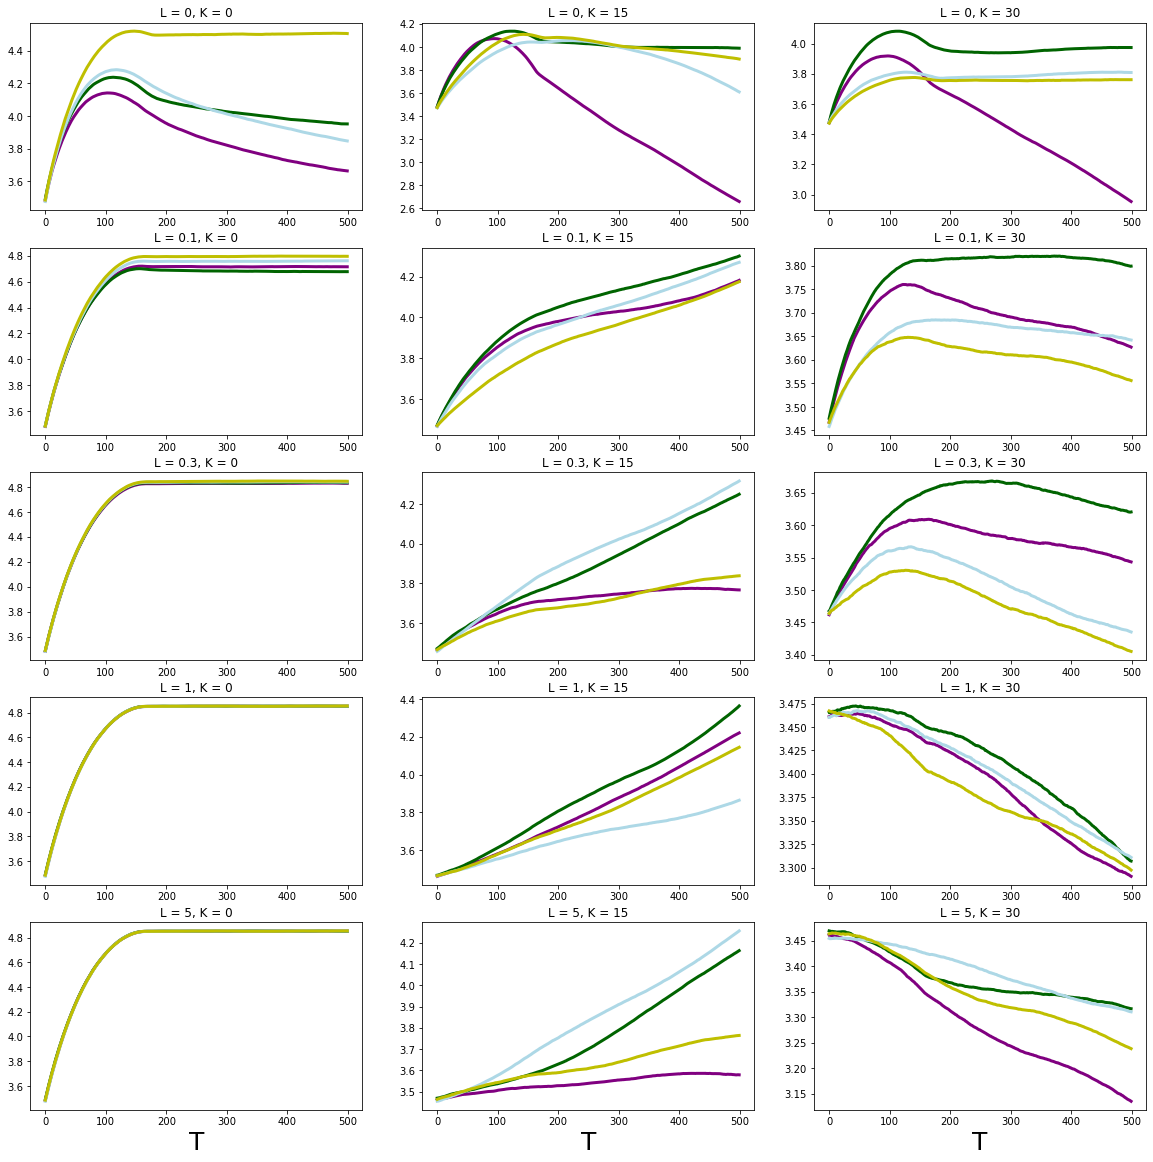

In [27]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.6, 0.2): "purple",
    (0.4, 0.4): "darkgreen",
    (0.4, 0.2): "lightblue",
    (0.2, 0.2): "y",
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.6, 0.2), (0.4, 0.4), (0.4, 0.2), (0.2, 0.2)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")

### Cenário 3 - Dois grupos polarizados.

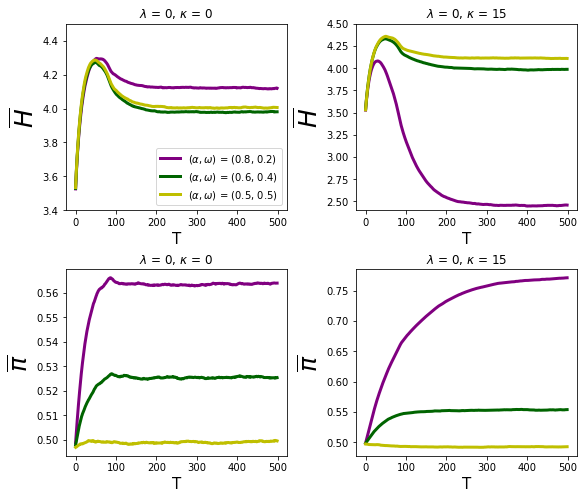

In [114]:
## from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout = True, figsize = (8, 12))
gs = GridSpec(4, 2, figure = fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("T", fontsize = 15)
    
ax1.set_ylim([3.4, 4.5])
ax2.set_ylim([2.4, 4.5])

ax1.set_ylabel(r"$\overline{H}$", fontsize = 25)
ax2.set_ylabel(r"$\overline{H}$", fontsize = 25)

ax3.set_ylabel(r"$\overline{\pi}$", fontsize = 25)
ax4.set_ylabel(r"$\overline{\pi}$", fontsize = 25)

colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

for i in range(len(alpha_omega)):
    param = ("barabasi", 500, 160, 5, 0, 0, alpha_omega[i][0], alpha_omega[i][1], 0, 2)
    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))
    
    ax1.plot(X, mean_entropy, label = rf'$(\alpha, \omega)$ = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)
    ax1.set_title(f"$\lambda$ = {0}, $\kappa$ = {0}")
    
for i in range(len(alpha_omega)):
    param = ("barabasi", 500, 160, 5, 15, 0, alpha_omega[i][0], alpha_omega[i][1], 0, 2)
    results = mean_stats[param]
    mean_entropy = results['Entropy']
    X = range(len(mean_entropy))
    
    ax2.plot(X, mean_entropy, label = rf'$(\alpha, \omega)$ = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)
    ax2.set_title(rf"$\lambda$ = {0}, $\kappa$ = {15}")
    
for i in range(len(alpha_omega)):
    param = ("barabasi", 500, 160, 5, 0, 0.1, alpha_omega[i][0], alpha_omega[i][1], 0, 2)
    results = mean_stats[param]
    mean_polarity = results['Polarity']
    X = range(len(mean_polarity))
    
    ax3.plot(X, mean_polarity, label = rf'$(\alpha, \omega)$ = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)
    ax3.set_title(rf"$\lambda$ = {0}, $\kappa$ = {0}")
    
for i in range(len(alpha_omega)):
    param = ("barabasi", 500, 160, 5, 15, 0.1, alpha_omega[i][0], alpha_omega[i][1], 0, 2)
    results = mean_stats[param]
    mean_polarity = results['Polarity']
    X = range(len(mean_polarity))
    
    ax4.plot(X, mean_polarity, label = rf'$(\alpha, \omega)$ = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)
    ax4.set_title(rf"$\lambda$ = {0}, $\kappa$ = {15}")
    
ax1.legend(fontsize = 10, loc = 4)

fig.savefig("cenario_3_grupamento_0_entropia.png", bbox_inches = "tight")

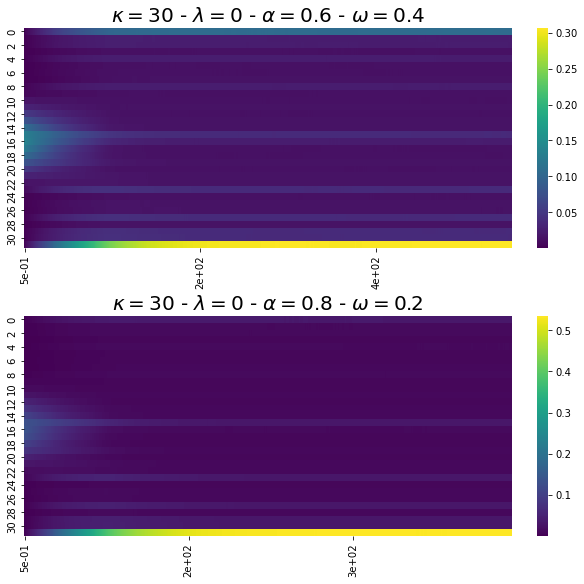

In [112]:
fig = plt.figure(constrained_layout = True, figsize = (8, 8))
gs = GridSpec(2, 1, figure = fig)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

lambd = 0
kappa = 30
alpha = 0.6
omega = 0.4
param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax1, cbar = True)
ax.set_title(r"$\kappa = 30$ - $\lambda = 0$ - $\alpha = 0.6$ - $\omega = 0.4$", fontsize = 20)

lambd = 0
kappa = 30
alpha = 0.8
omega = 0.2
param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
_, ax = heat_plot(results, cmap = 'viridis', fig = fig, ax = ax2, cbar = True)
ax.set_title(r"$\kappa = 30$ - $\lambda = 0$ - $\alpha = 0.8$ - $\omega = 0.2$", fontsize = 20)

fig.savefig("cenario_3_grupamento_0_evolucao_dist.png", bbox_inches = "tight")

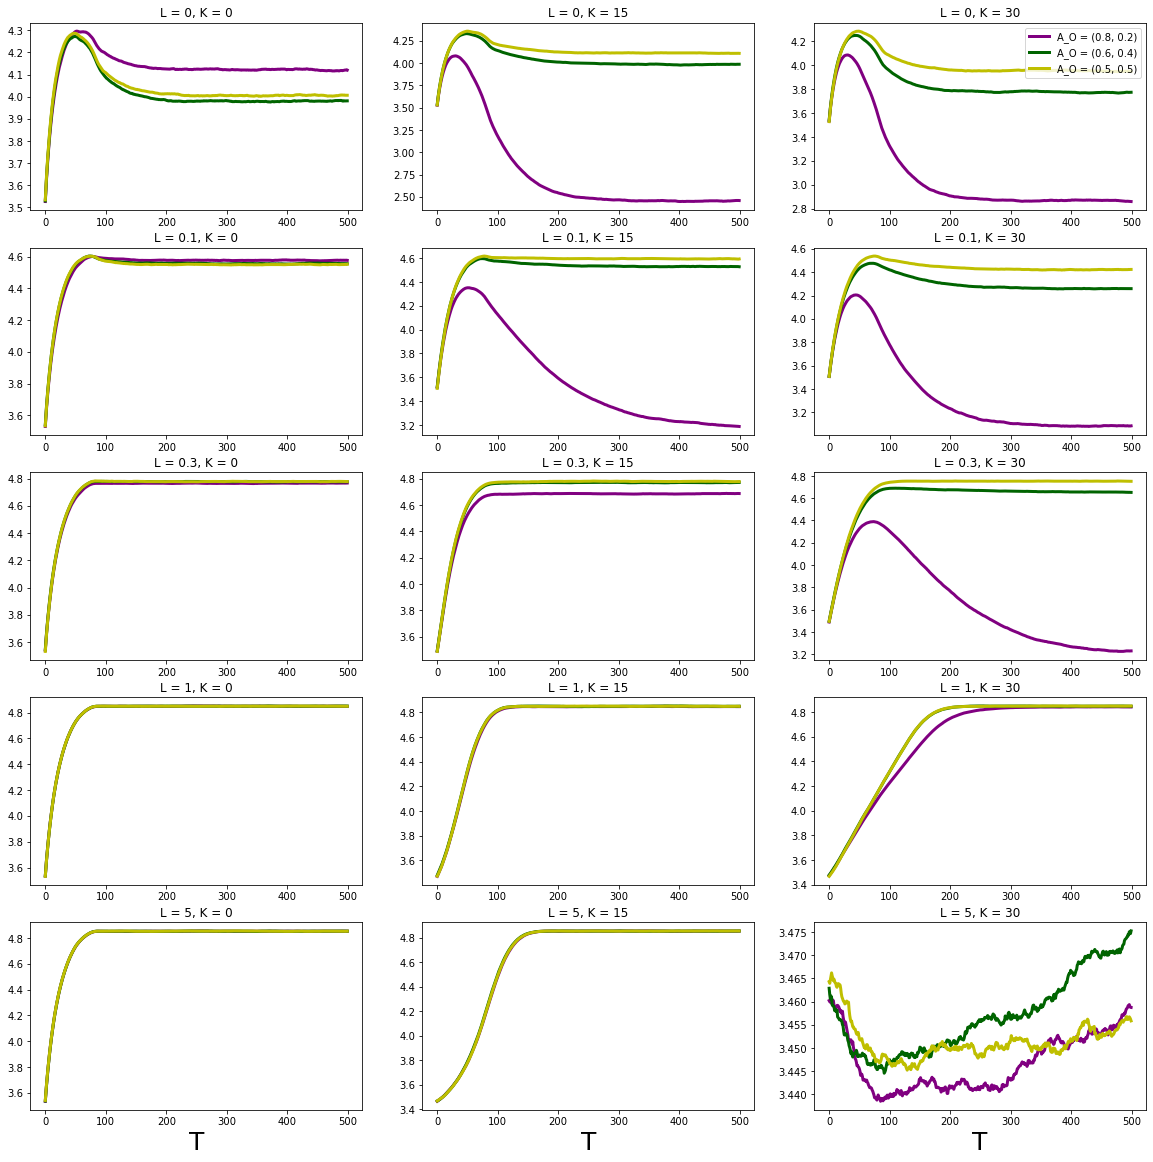

In [56]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

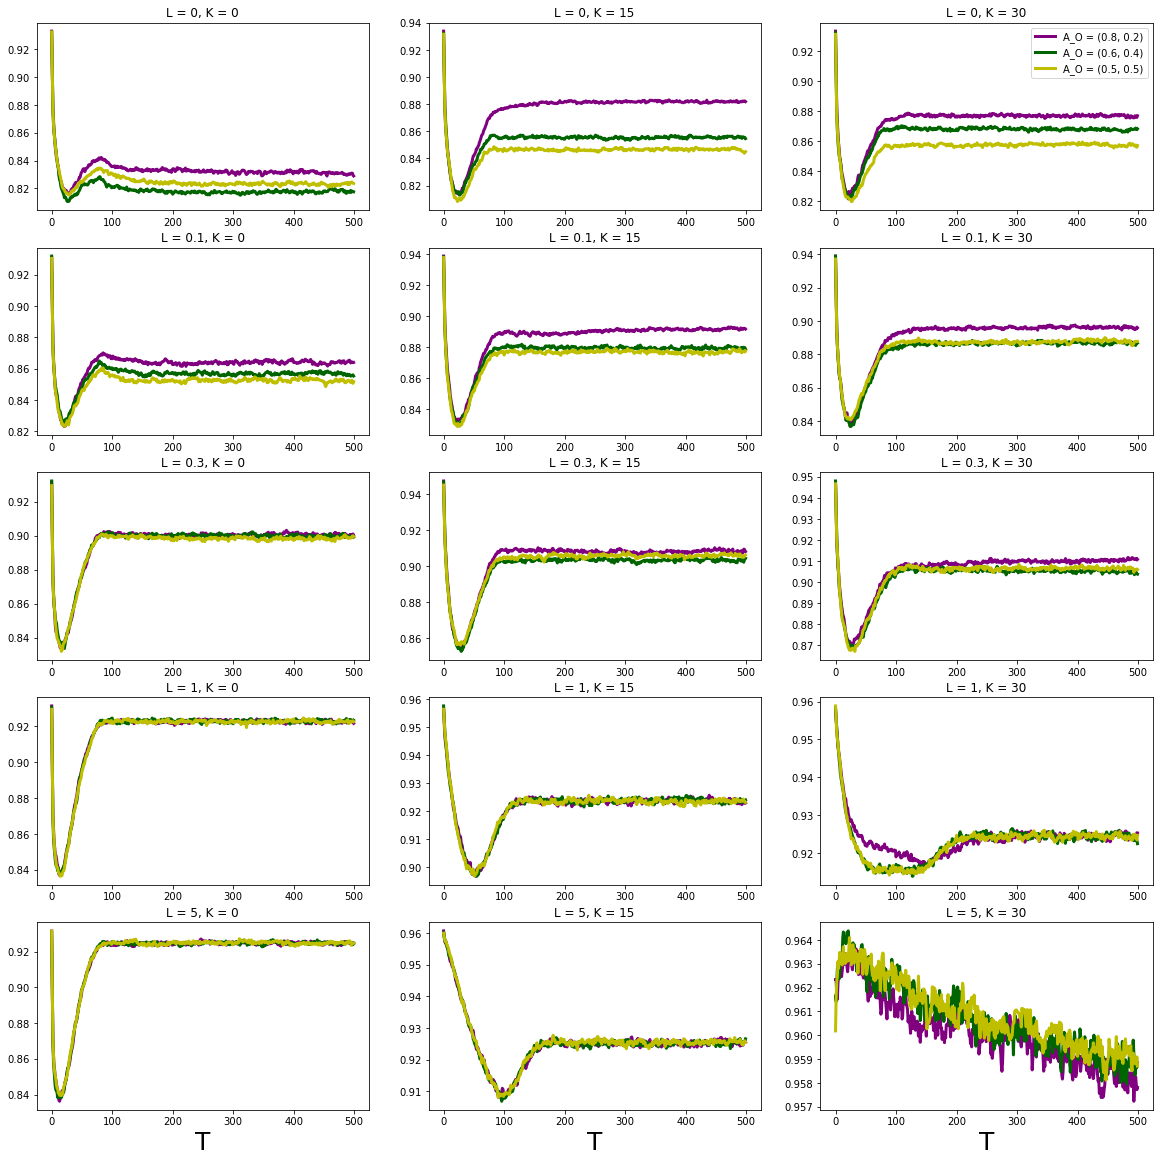

In [61]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_proximity = results['Proximity']
            X = range(len(mean_proximity))

            axs[k][j].plot(X, mean_proximity, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

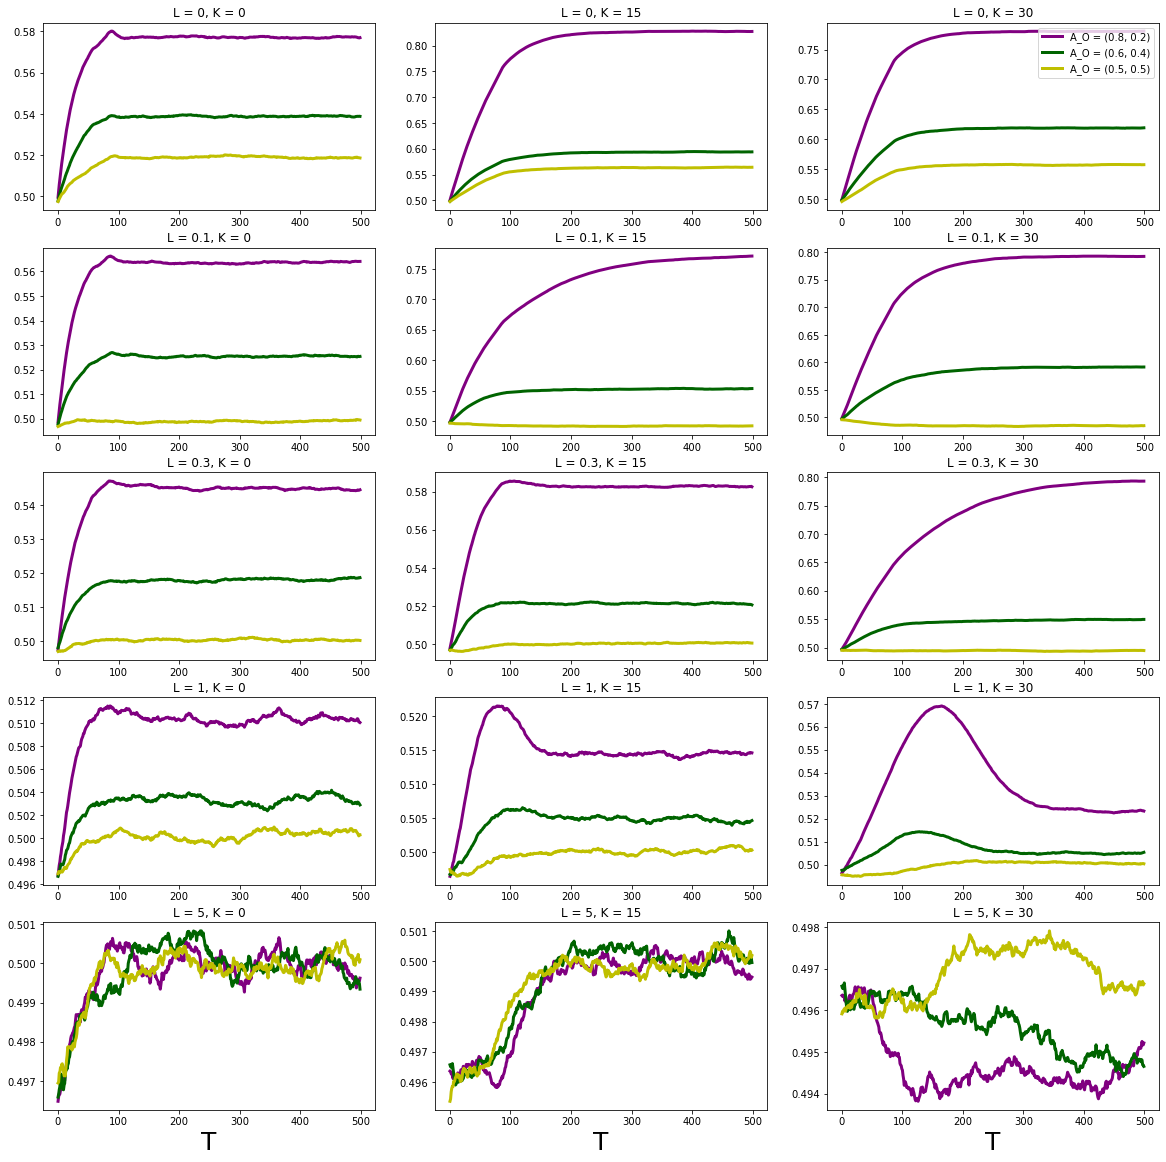

In [30]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], 0, 2)

            results = mean_stats[param]
            mean_entropy = results['Polarity']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")
            
axs[0][2].legend(fontsize = 10, loc = 1)

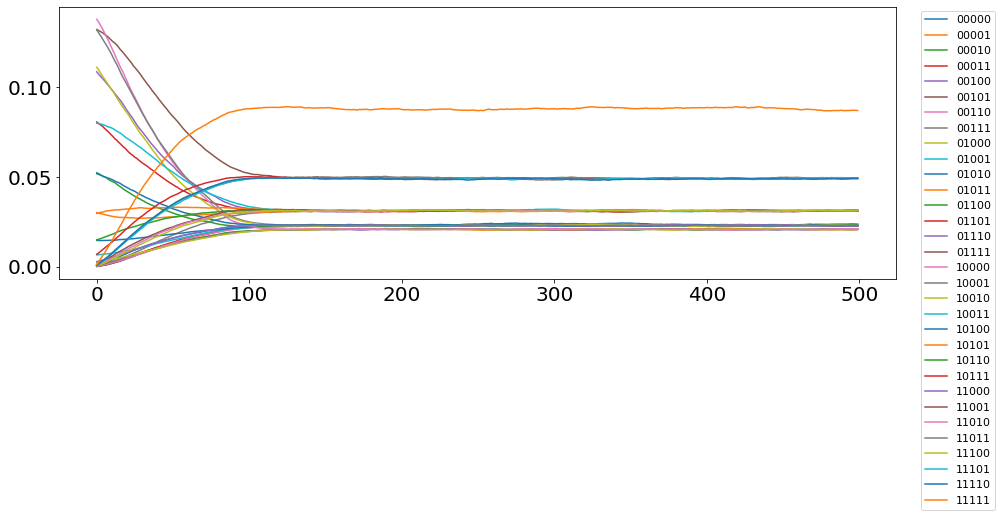

In [49]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0.3
kappa = 15
alpha = 0.8
omega = 0.2

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

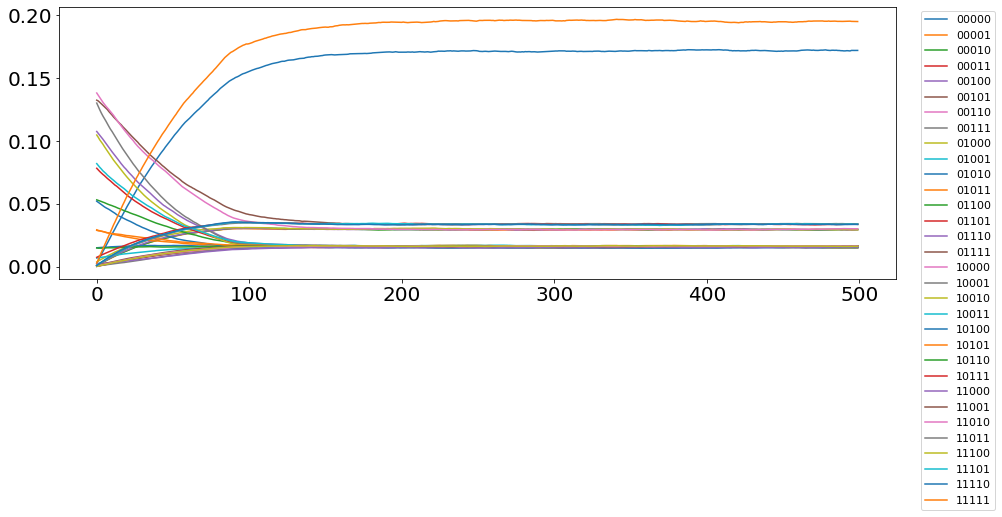

In [29]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (15, 5))

# ax.locator_params(axis='x', nbins=5)
# ax.locator_params(axis='y', nbins=5)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='both', which='minor', labelsize=20)

getbinary = lambda x, n: format(x, 'b').zfill(n)

lambd = 0
kappa = 0
alpha = 0.5
omega = 0.5

param = ("barabasi", 500, 160, 5, kappa, lambd, alpha, omega, 0, 2)
results = mean_stats[param]['Distribution']
X = np.arange(results.shape[1])

for k in range(len(results)):
    ax.plot(X, results[k], label = f"{getbinary(k, 5)}")
    
ax.legend(fontsize = 11, loc = (1.03, -.85))
# axs[0].set_title(rf"Evolução Temporal das Probabilidades das Informações ($T = 0$ até $T = 2000$); $\kappa = \gamma = 0$", fontsize = 18)
    
# params = ('barabasi', 1000, 160, 5, 0, 0, 0, 0, 0, 2)
# results = pickle.load(open(f"{'barabasi'}_{1000}_{160}_{5}_{0}_{0}_{0}_{0}_{0}_{2}_partial_results.pickle", "rb"))
# _results = results[params][0]['Distribution'].T
# X = np.arange(_results.shape[1])[100:2000]

# for k in range(len(_results)):
#     axs[1].plot(X, _results[k][100:2000], label = f"{k}")

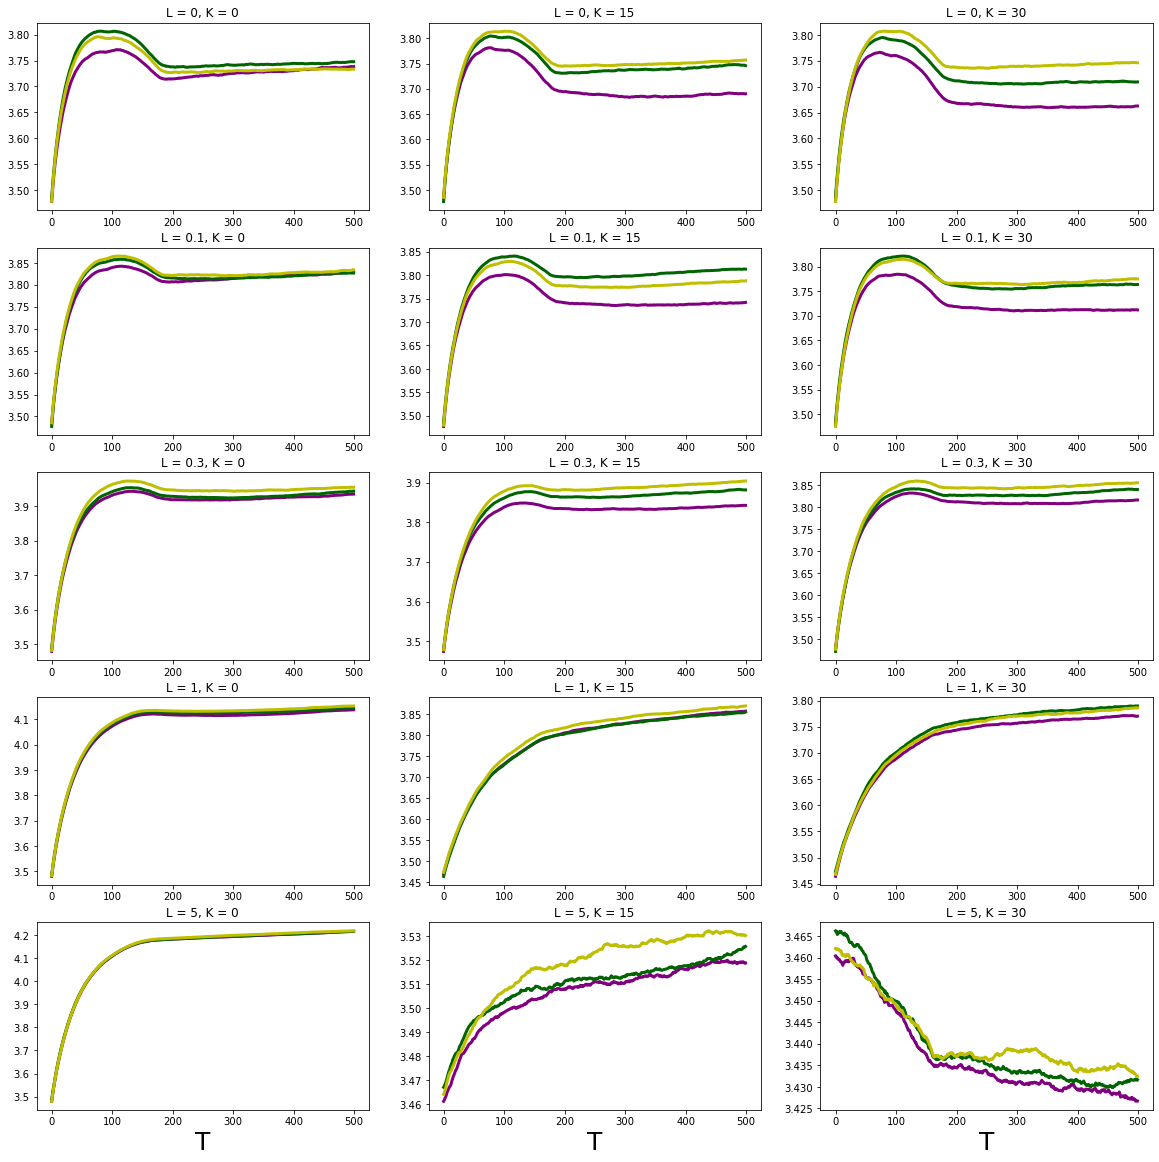

In [22]:
fig, axs = plt.subplots(ncols = 3, nrows = 5, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.18)
for ax in axs[4]:
    ax.set_xlabel("T", fontsize = 25)
    
colors = {
    (0.8, 0.2): "purple",
    (0.6, 0.4): "darkgreen",
    (0.5, 0.5): "y"
}

style = {
    0: '--',
    15: '-',
    30: ':'
}

alpha_omega = [(0.8, 0.2), (0.6, 0.4), (0.5, 0.5)]

alpha = [1, 0.8, 0.6, 0.4, 0.2]

for i in range(len(alpha_omega)):
    for j in range(len(param_list['kappa'])):
        for k in range(len(param_list['lambda'])):
            param = ("barabasi", 500, 160, 5, param_list['kappa'][j], param_list['lambda'][k], alpha_omega[i][0], alpha_omega[i][1], -10, 2)

            results = mean_stats[param]
            mean_entropy = results['Entropy']
            X = range(len(mean_entropy))

            axs[k][j].plot(X, mean_entropy, label = f'A_O = {alpha_omega[i]}', color = colors[alpha_omega[i]], linewidth = 3)

            axs[k][j].set_title(f"L = {param_list['lambda'][k]}, K = {param_list['kappa'][j]}")